### Edgar Moises Hernandez-Gonzalez
#### 23/07/20-24/07/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 67x500
##### Validacion cruzada

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense)
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_train_9.csv", header=None).values
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_test_9.csv", header=None).values

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [7]:
x = pd.concat([x_train, x_test])
y = np.concatenate((y_train, y_test))

In [8]:
print(x.shape)
print(y.shape)

(720, 3000)
(720, 1)


In [9]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 720


In [10]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [11]:
#unir 3 canales
def unir_escalogramas_vertical(data):
  dim = (500, 67) #ancho, alto
  fs = 250
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],67,500))
  temporal = np.zeros((135,1000))
  for i in range(data.shape[0]): #n muestras
    for j in range(3): #3 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      # escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / fs))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [12]:
# unir_escalogramas_vertical_resize(data):
inicio = time.time()

x = unir_escalogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
400
500
600
700
Tiempo: 42.34332990646362


In [13]:
print(x.shape)

(720, 67, 500)


In [14]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

14.436868751355295
0.008739063517846717
0.8687564733950387


In [15]:
#convertir a float
x = x.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [16]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.9624579
0.00058260426
0.057917062


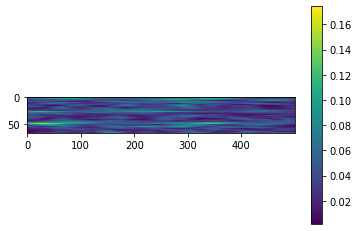

In [17]:
plt.figure()
plt.imshow(x[1])
plt.colorbar()
plt.show()

In [18]:
#convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(720, 1, 67, 500, 1)


In [19]:
skf = StratifiedKFold(n_splits = 10)

In [20]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8, activation='tanh', dropout=0.5))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.8494291835361056
accuracy:  0.6805555820465088
kappa:  0.36111111111111116
confusion matrix:
 [[17 19]
 [ 4 32]]


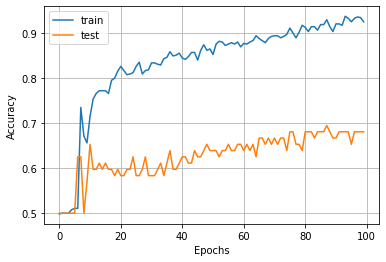

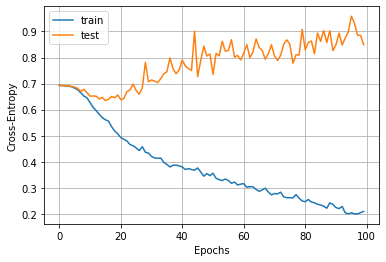


Iteration: 2
loss:  0.9867373572455512
accuracy:  0.5972222089767456
kappa:  0.19444444444444442
confusion matrix:
 [[20 16]
 [13 23]]


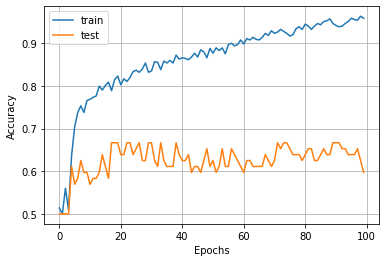

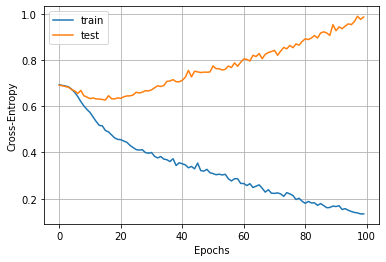


Iteration: 3
loss:  0.9985792636871338
accuracy:  0.625
kappa:  0.25
confusion matrix:
 [[19 17]
 [10 26]]


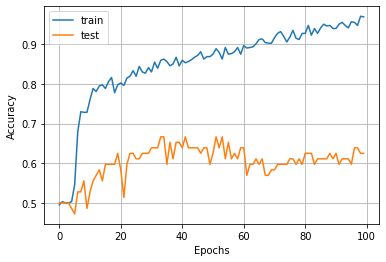

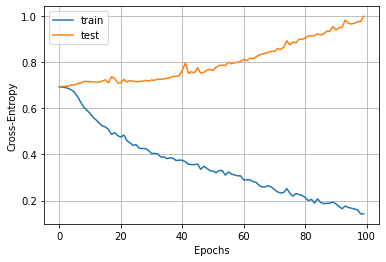


Iteration: 4
loss:  0.5515714618894789
accuracy:  0.7083333134651184
kappa:  0.41666666666666663
confusion matrix:
 [[29  7]
 [14 22]]


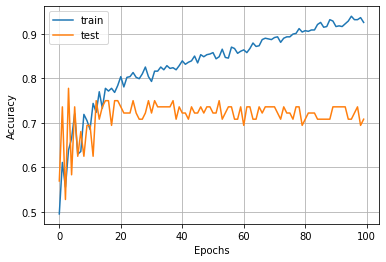

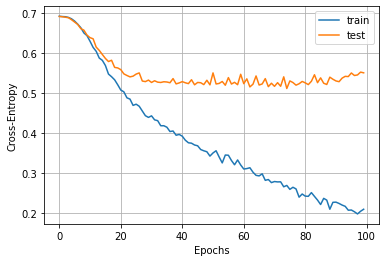


Iteration: 5
loss:  0.32799582017792595
accuracy:  0.8333333134651184
kappa:  0.6666666666666667
confusion matrix:
 [[27  9]
 [ 3 33]]


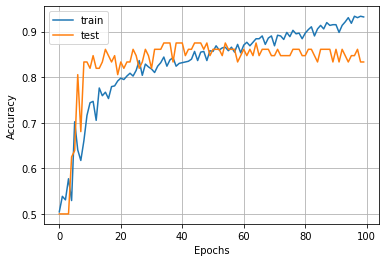

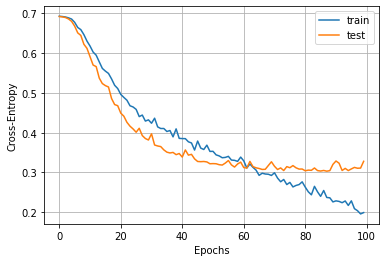


Iteration: 6
loss:  0.3699423174063365
accuracy:  0.8611111044883728
kappa:  0.7222222222222222
confusion matrix:
 [[28  8]
 [ 2 34]]


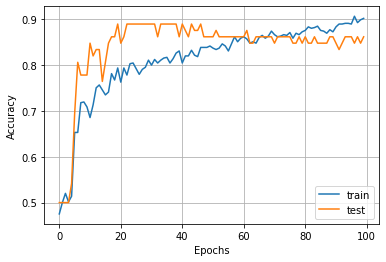

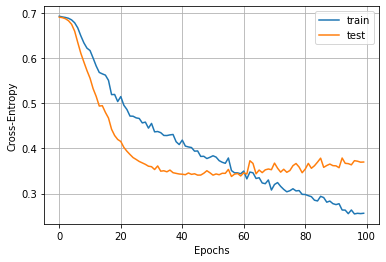


Iteration: 7
loss:  0.3796372272902065
accuracy:  0.8333333134651184
kappa:  0.6666666666666667
confusion matrix:
 [[26 10]
 [ 2 34]]


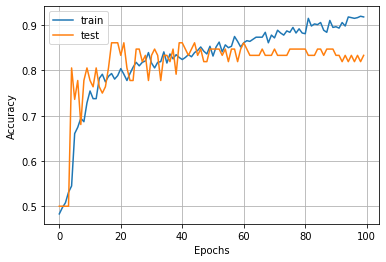

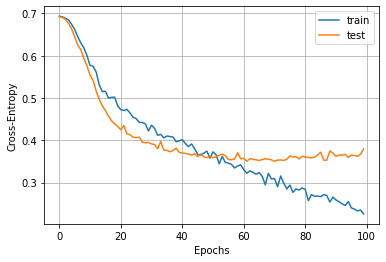


Iteration: 8
loss:  0.258091539144516
accuracy:  0.875
kappa:  0.75
confusion matrix:
 [[34  2]
 [ 7 29]]


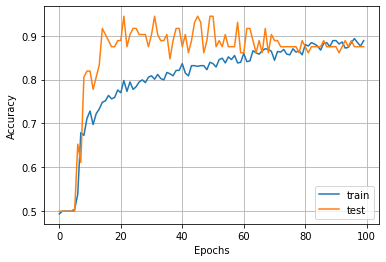

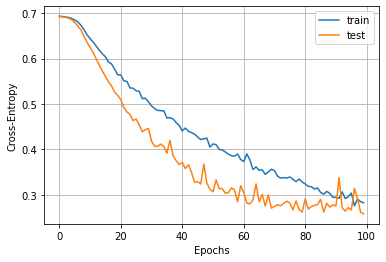


Iteration: 9
loss:  0.374902729358938
accuracy:  0.8055555820465088
kappa:  0.6111111111111112
confusion matrix:
 [[26 10]
 [ 4 32]]


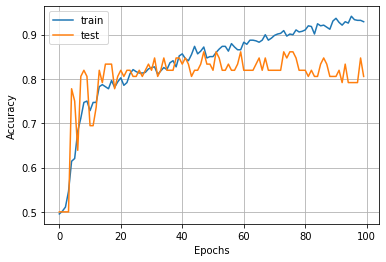

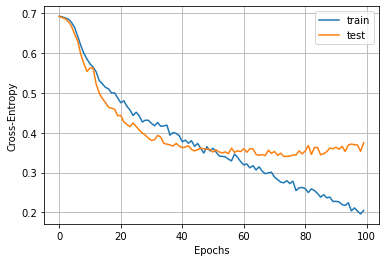


Iteration: 10
loss:  0.6649610035949283
accuracy:  0.7638888955116272
kappa:  0.5277777777777778
confusion matrix:
 [[33  3]
 [14 22]]


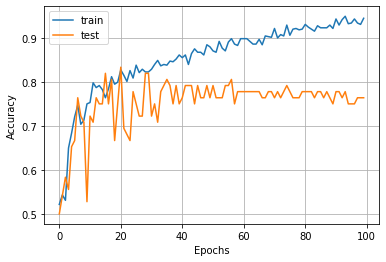

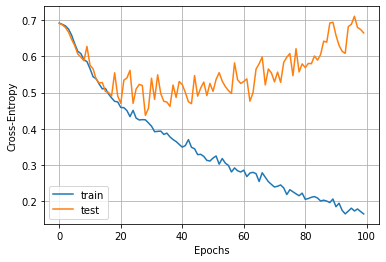


Resultados:
loss: [0.8494291835361056, 0.9867373572455512, 0.9985792636871338, 0.5515714618894789, 0.32799582017792595, 0.3699423174063365, 0.3796372272902065, 0.258091539144516, 0.374902729358938, 0.6649610035949283]
accuracy: [0.6805555820465088, 0.5972222089767456, 0.625, 0.7083333134651184, 0.8333333134651184, 0.8611111044883728, 0.8333333134651184, 0.875, 0.8055555820465088, 0.7638888955116272]
kappa: [0.36111111111111116, 0.19444444444444442, 0.25, 0.41666666666666663, 0.6666666666666667, 0.7222222222222222, 0.6666666666666667, 0.75, 0.6111111111111112, 0.5277777777777778]
Tiempo: 484.84074115753174


In [21]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=100, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [22]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 1, 67, 500, 8)     80        
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 33, 250, 8)     0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 1, 33, 250, 8)     584       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 1, 16, 125, 8)     0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 1, 16000)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 512288    
_________________________________________________________________
dense_19 (Dense)             (None, 16)              

In [23]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7583
std: (+/- 0.0949)
Mean Kappa: 0.5167
std: (+/- 0.1897)
Max Accuracy: 0.8750
Max Kappa: 0.7500
Tiempo: 484


In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 24 17:53:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    88W / 149W |   1287MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------